(loc_scale_notebook)=
# Indici di posizione e di scala

L’analisi grafica esaminata in precedenza costituisce la base di
partenza di qualsivoglia analisi quantitativa dei dati. Tramite
opportune rappresentazioni grafiche possiamo individuare alcune
caratteristiche importanti di una distribuzione: per esempio, è
possibile capire se la distribuzione è simmetrica o asimmetrica; oppure
se è unimodale o multimodale. Successivamente, è necessario calcolare
degli indici numerici che descrivano in modo sintetico le
caratteristiche di base dei dati. In questo capitolo verranno introdotti
i principali indicatori della statistica descrittiva.

## Indici di tendenza centrale

Tra le misure di tendenza centrale, ovvero tra gli indici che ci
informano sui valori attorno ai quali sono prevalentemente concentrati i
dati di un campione, quella più comunemente usata è la media.

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from scipy.constants import golden

In [3]:
%matplotlib inline
plt.rc('figure', figsize=(5.0, 5.0/golden))
sns.set_theme()
sns.set_palette("colorblind")
SEED = 12345
rng = np.random.default_rng(SEED)

Per un’introduzione “soft” alla nozione di tendenza centrale di una
distribuzione statistica si segua il
[link](https://tinystats.github.io/teacups-giraffes-and-statistics/03_mean.html).

### Media

Tutti conosciamo la media aritmetica di $\{x_1, x_2, \dots, x_n\}$,
ovvero il numero reale $\bar{x}$ definito da

$$
\bar{x}=\frac{1}{n}\sum_{i=1}^n x_i.
$$ (eq-mean)

Nella @eq-mean ho usato la notazione delle sommatorie per descrivere una
somma di valori. Questa notazione è molto usata in statistica e viene
descritta in Appendice.

La media gode della seguente importante proprietà: la somma degli scarti
tra ciascuna modalità $x_i$ e la media aritmetica $\bar{x}$ è nulla,
cioè

$$
\sum_{i=1}^n (x_i - \bar{x}) = 0.\notag
$$ (eq-diffmeansumzero)

Infatti,

$$
\begin{aligned}
\sum_{i=1}^n (x_i - \bar{x}) &= \sum_i x_i - \sum_i \bar{x}\notag\\
&= \sum_i x_i - n \bar{x}\notag\\
&= \sum_i x_i - \sum_i x_i = 0.\notag
\end{aligned}
$$

Ciò ci consente di pensare alla media come al baricentro della
distribuzione.

Un’altra proprietà della media è la seguente. La somma dei quadrati
degli scarti tra ciascuna modalità $x_i$ e una costante arbitraria $a$,
cioè

$$
\varphi(a) = \sum_{i=1}^n (x_i - a)^2,\notag
$$ (eq-minsq)

è minima per $a = \bar{x}$.

Il concetto statistico di media ha suscitato molte battute. Per esempio,
il fatto che, in media, ciascuno di noi ha un numero di gambe circa pari
a 1.9999999. Oppure, il fatto che, in media, ciascuno di noi ha un
testicolo. Ma la media ha altri problemi, oltre al fatto di ispirare
battute simili alle precedenti. In particolare, dobbiamo notare che la
media non è sempre l’indice che meglio rappresenta la tendenza centrale
di una distribuzione. In particolare, ciò non accade quando la
distribuzione è asimmetrica, o in presenza di valori anomali (*outlier*)
In tali circostanze, la tendenza centrale della distribuzione è meglio
rappresentata dalla mediana o dalla media spuntata (si veda più sotto).

Per fare un esempio, calcoliamo la media dei valori BDI-II separatamente per ciascuno dei due
gruppi di soggetti esaminati da {cite}`zetsche_2019future`.

In [4]:
# Leggo i dati, seleziono le colonne appropriate, elimino i duplicati, rimuovo 
# il dato mancante.
df = pd.read_csv('data/data.mood.csv',index_col=0)
df = df[['esm_id','group','bdi']]
df = df.drop_duplicates(keep='first')
df = df[pd.notnull(df['bdi'])]
df.shape

(66, 3)

In [30]:
df

,esm_id,group,bdi
1,10,mdd,25.0
15,9,mdd,30.0
30,6,mdd,26.0
46,7,mdd,35.0
65,12,mdd,44.0
...,...,...,...
1105,99,ctl,0.0
1121,100,ctl,2.0
1133,104,ctl,0.0
1152,103,ctl,0.0


In [5]:
df.groupby("group").size()

group
ctl    36
mdd    30
dtype: int64

<AxesSubplot: xlabel='bdi'>

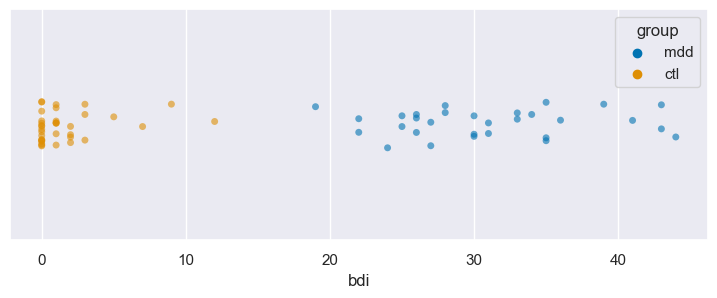

In [6]:
_ = sns.stripplot(x="bdi", data=df, jitter=0.1, hue="group", alpha=0.6)

Trovo le medie dei valori BDI-II dei due gruppi.

In [7]:
df.groupby('group')['bdi'].mean().round(1)

group
ctl     1.6
mdd    30.9
Name: bdi, dtype: float64

Oppure

In [8]:
df.groupby('group')['bdi'].describe().round(1)

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
ctl,36.0,1.6,2.7,0.0,0.0,1.0,2.0,12.0
mdd,30.0,30.9,6.6,19.0,26.0,30.0,35.0,44.0


In [9]:
bdi_mdd = df[df["group"]=='mdd']['bdi']
len(bdi_mdd)

30

In [38]:
print(*bdi_mdd)

25.0 30.0 26.0 35.0 44.0 30.0 22.0 33.0 43.0 43.0 24.0 39.0 19.0 25.0 31.0 28.0 30.0 35.0 31.0 26.0 36.0 41.0 26.0 35.0 33.0 28.0 27.0 34.0 22.0 27.0


In [42]:
sum(bdi_mdd) / len(bdi_mdd)

30.933333333333334

Si noti come abbiamo selezionato le osservazioni del gruppo `mdd`. In alternativa, si può usare la sintassi seguente.

In [10]:
df_group = df.groupby("group")
mdd_group = df_group.get_group('mdd')
len(mdd_group['bdi'])

30

In [49]:
print(*mdd_group['bdi'])

25.0 30.0 26.0 35.0 44.0 30.0 22.0 33.0 43.0 43.0 24.0 39.0 19.0 25.0 31.0 28.0 30.0 35.0 31.0 26.0 36.0 41.0 26.0 35.0 33.0 28.0 27.0 34.0 22.0 27.0


### Media spuntata

La *media spuntata* $\bar{x}_t$ (*trimmed mean*) non è altro che la
media dei dati calcolata considerando solo il 90% (o altra percentuale)
dei dati centrali. Per calcolare $\bar{x}_t$ si ordinando i dati secondo
una sequenza crescente, $x_1 \leq x_2 \leq x_3 \leq \dots \leq x_n$, per
poi eliminare il primo 5% e l’ultimo 5% dei dati della serie così
ordinata. La media spuntata è data dalla media aritmetica dei dati
rimanenti.

Per fare un esempio, calcoliamo la media spuntata dei valori BDI-II per i due gruppi di
soggetti esaminati da {cite}`zetsche_2019future` escludendo il 10% dei valori
più estremi. Iniziamo ad esaminare la numerosità di ciascun gruppo.

In [ ]:
df.groupby("group").size()

Possiamo selezionare i dati del gruppo `mdd` nel modo seguente.

In [ ]:
df[df["group"]=='mdd']

Calcoliamo ora la media spuntata dei due gruppi.

In [ ]:
bdi_mdd = df[df["group"]=='mdd'].bdi
stats.trim_mean(bdi_mdd, 0.10)

bdi_ctl = df[df["group"]=='ctl'].bdi
stats.trim_mean(bdi_ctl, 0.10)

### Moda e mediana

In precedenza abbiamo già incontrato altri due popolari indici di
tendenza centrale: la *moda* (*Mo*), ovvero il valore centrale della
classe con la frequenza massima (può succedere che una distribuzione
abbia più mode; in tal caso si dice *multimodale* e questo operatore
perde il suo significato di indice di tendenza centrale) e la *mediana*
$\tilde{x}$.

Si calcolino i quantili di ordine 0.25, 0.5 e 0.75 dei valori BDI-II per
i due gruppi di soggetti di {cite}`zetsche_2019future`.

In [ ]:
#create functions to calculate 0.10 and 0.90 quantiles
def q1(x):
    return x.quantile(0.10)

def q3(x):
    return x.quantile(0.90)

#calculate quantiles by group
vals = {'bdi': [q1, q3]}
df.groupby('group').agg(vals)

Si noti che solitamente i software restituiscono un valore *interpolato*
del $p$-esimo quantile $q_p$ $(0 < p < 1)$, il quale viene calcolato
mediante specifiche procedure. Il risultato fornito dai software,
dunque, non sarà identico a quello trovato utilizzando la definizione
non interpolata di quantile che abbiamo presentato in precedenza. Se,
per qualche ragione, vogliamo conoscere l’algoritmo usato per la
determinazione dei quantili interpolati, dobbiamo leggere la
documentazione del software.

## Indici di dispersione

Le medie e gli indici di posizione descritti in precedenza forniscono
delle sintesi dei dati che mettono in evidenza la tendenza centrale
delle osservazioni. Tali indici, tuttavia, non considerano un aspetto
importante della distribuzione dei dati, ovvero la variabilità dei
valori numerici della variabile statistica. È dunque necessario
sintetizzare la distribuzione di una variabile statistica oltre che con
le misure di posizione anche tramite l’utilizzo di indicatori che
valutino la dispersione delle unità statistice.

Per un’introduzione “soft” al tema degli indici di dispersione si segua
il
[link](https://tinystats.github.io/teacups-giraffes-and-statistics/04_variance.html).

### Indici basati sull’ordinamento dei dati

È possibile calcolare degli indici di variabilità basati
sull’ordinamento dei dati. L’indice più ovvio è l’*intervallo di
variazione*, ovvero la distanza tra il valore massimo e il valore minimo
di una distribuzione di modalità, mentre in precedenza abbiamo già
incontrato la *differenza interquartile*. Questi due indici, però, hanno
il limite di essere calcolati sulla base di due soli valori della
distribuzione ($x_{\text{max}}$ e $x_{\text{min}}$, oppure $x_{0.25}$ e
$x_{0.75}$). Pertanto non utilizzano tutte le informazioni che sono
disponibili. Inoltre, l’intervallo di variazione ha il limite di essere
pesantemente influenzato dalla presenza di valori anomali.

### Varianza

Dati i limiti delle statistiche precedenti è più comune misurare la
variabilità di una variabile statistica come la dispersione dei dati
attorno ad un indice di tendenza centrale. Infatti, la misura di
variabilità di gran lunga più usata per valutare la variabilità di una
variabile statistica è senza dubbio la varianza. La varianza

$$
\begin{equation}
S^2 = \frac{1}{n} \sum_{i=1}^n (x_i - \bar{x})^2
\end{equation}
$$ (eq-var-descr)

è la media dei quadrati degli scarti $x_i - \bar{x}$ tra ogni valore e
la media della distribuzione.

La varianza è una misura di dispersione più complessa di quelle
esaminate in precedenza. È appropriata solo nel caso di distribuzioni
simmetriche e, anch’essa, è fortemente influenzata dai valori anomali.
Inoltre, è espressa in un’unità di misura che è il quadrato dell’unità
di misura dei dati originari e quindi ad essa non può essere assegnata
un’interpretazione intuitiva.

Calcoliamo ora varianza dei valori BDI-II per i dati di {cite}`zetsche_2019future`. Applicando l'eq. {eq}`eq-var-descr` formula precedente, per tutto il campione abbiamo

In [ ]:
var_bdi = sum((df.bdi - np.mean(df.bdi))**2) / len(df.bdi)
round(var_bdi, 4)

Possiamo anche usare le funzioni di `numpy`.

In [ ]:
var_bdi = np.var(df.bdi)
round(var_bdi, 4)

#### Stima della varianza della popolazione

Si noti il denominatore della formula della varianza. Nell'eq.{eq}`eq-var-descr`
ho usato $n$ (l’ampiezza campionaria, ovvero il numero di osservazioni
del campione). In questo modo ottengo la varianza quale *statistica
descrittiva* del campione. In alternativa, è possibile usare $n-1$ al
denominatore:

$$
\begin{equation}
s^2 = \frac{1}{n-1} \sum_{i=1}^n (x_i - \bar{x})^2
\end{equation}
$$ (eq-var-stimatore)

In questo secondo modo si trova la varianza quale *stimatore* della
varianza della popolazione. Si può dimostrare che l’@eq-var-stimatore
fornisce una stima corretta (ovvero, non distorta) della varianza della
popolazione da cui abbiamo ottenuto il campione, mentre invece la
@eq-var-descr fornisce (in media) una stima troppo piccola della
varianza della popolazione. Si presti attenzione alla notazione: $S^2$
per la varianza quale statistica descrittiva, $s^2$ per la varianza
quale stimatore.

Per illustrare il punto precedente svolgiamo una simulazione.

Estraggo un campione casuale di 10 osservazioni dalla popolazione del
quoziente di intelligenza.

In [23]:
x = rng.normal(loc=100, scale=15, size=10)
print(x)

[ 92.05330378  92.73039294  95.77077133  82.70158264  86.92719913
  93.32300637  96.81037032 106.61621404  93.92996301 117.29994044]


Calcolo la varianza con $n$ al denominatore. Si noti che la “vera”
varianza del quoziente di intelligenza è $15^2$ = 225.

In [12]:
np.var(x)

82.85077945332272

Consideriamo ora 10 campioni casuali del QI.

In [18]:
mu = 100
sigma = 15
size = 4
niter = 10
random_samples = []

for i in range(niter):
    one_sample = rng.normal(loc=mu, scale=sigma, size=size)
    random_samples.append(one_sample)

Il primo campione è

In [ ]:
random_samples[0]

Il decimo campione è

In [ ]:
random_samples[9]

Stampiamo tutti e 10 i campioni.

In [16]:
rs = np.array(random_samples)
rs

array([[ 81.22558714,  71.53317275, 101.38725837, 113.56554631],
       [110.88279291,  94.52391778, 109.68241659, 100.26476159],
       [ 90.83183428,  81.33227455, 105.8014978 , 114.95544317],
       [ 88.34838332, 104.5424679 , 113.15261163, 111.40132217],
       [116.21756826, 105.58321177, 109.74749632,  75.77056952],
       [ 89.26122752, 103.14911381,  81.69404495,  78.86916795],
       [ 84.44900944,  79.46085739,  99.77977693,  72.45833615],
       [ 97.08870205, 100.00091642,  70.66521685, 102.64267493],
       [106.92687703,  83.24137126,  93.13104003,  82.79928942],
       [137.81116407,  74.95954065,  84.19793264, 108.59160089]])

Per ciascun campione (ovvero, per ciascuna riga della matrice
precedente), calcoliamo la varianza usando $n$ al denominatore.
Otteniamo così 10 stime della varianza della popolazione del QI.

In [17]:
x_var = np.var(rs, axis=1) # applichiamo la funzione su ciascuna riga
print(x_var)

[272.03789969  45.82661796 169.33350236  95.82384864 240.71734588
  88.49663879 100.75282876 164.22801     96.13842761 593.1251523 ]


Ripetiamo ora la simulazione usando un numero di iterazioni maggiore.

In [20]:
loc = 100
scale = 15
size = 4
niter = 10000
random_samples = []

for i in range(niter):
    one_sample = rng.normal(loc=mu, scale=sigma, size=size)
    random_samples.append(one_sample)

rs = np.array(random_samples)
x_var = np.var(rs, axis=1);

Esaminiamo la distribuzione dei valori ottenuti.

<AxesSubplot: ylabel='Count'>

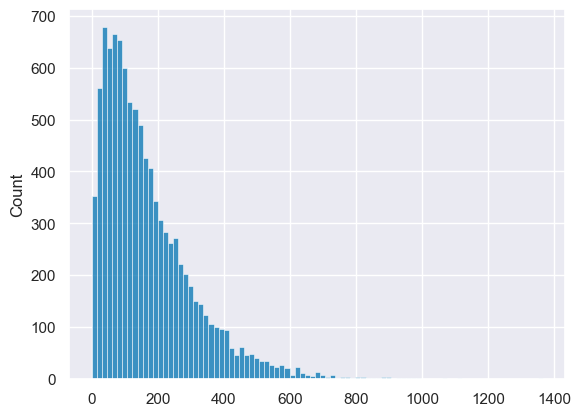

In [21]:
_ = sns.histplot(x_var)

La stima più verosimile della varianza del QI è dato dalla media di
questa distribuzione.

In [22]:
np.mean(x_var)

168.30207939405307

Si noti che il valore medio della stima della varianza ottenuta con
l'eq.{eq}`eq-var-descr` è troppo piccolo rispetto al valore corretto di
$15^2 = 225$. Ripeto ora la simulazione usando la formula della varianza con $n-1$ al
denominatore.

In [19]:
mu = 100
sigma = 15
size = 4
niter = 10000
random_samples = []

for i in range(niter):
    one_sample = rng.normal(loc=mu, scale=sigma, size=size)
    random_samples.append(one_sample)

rs = np.array(random_samples)
x_var = np.var(rs, ddof=1, axis=1)

np.mean(x_var)

224.611951512257

In questo secondo caso, il *valore atteso* della stima della varianza
trovata con $n-1$ al denominatore è molto simile al valore corretto di
225.

### Precisione

Si definisce *precisione* l’inverso della varianza:

$$
\tau = \frac{1}{\sigma^2}.
$$ (eq-precision)

Alcuni ritengono che la precisione sia più “intuitiva” della varianza
perché dice quanto sono concentrati i valori attorno alla media
piuttosto che quanto sono dispersi. In altri termini, si potrebbe
argomentare che siamo più interessati a quanto sia precisa una
misurazione piuttosto che a quanto sia imprecisa. Più sono dispersi i
valori attorno alla media (alta varianza), meno sono precisi (poca
precisione); minore è la varianza, maggiore è la precisione.

La precisione è uno dei due parametri naturali della distribuzione
gaussiana. Nei termini della @eq-precision, la distribuzione gaussiana
(si veda il Capitolo @distr-rv-cont) può essere espressa nel modo
seguente

$$
{\displaystyle f(y)=\sqrt{\frac{\tau}{2\pi}} e^{-{\frac {1}{2}}\tau\left({y-\mu }\right)^{2}}},
$$

anziché come

$$
{\displaystyle f(y)={\frac {1}{\sigma {\sqrt {2\pi }}}}e^{-{\frac {1}{2}}\left({\frac {y-\mu }{\sigma }}\right)^{2}}}.
$$

### Deviazione standard

Dato che l’unità di misura della varianza coincide con il quadrato
dell’unità di misura dei dati, la varianza è difficile da interpretare.
Questo problema si può risolvere prendendo la radice quadrata della
varianza, ottenendo così una misura espressa nell’unità di misura
originaria dei dati. Una tale misura si chiama *deviazione standard* (o
*scarto quadratico medio*, o *scarto tipo*)[1]:

$$
s^2 = \sqrt{(n-1)^{-1} \sum_{i=1}^n (x_i - \bar{x})^2}
$$ (eq-sd-stimatore)

Quando tutte le osservazioni sono uguali, $s = 0$, altrimenti $s > 0$.

```{admonition} Nota
Il termine *standard deviation* è stato introdotto in statistica da
Pearson nel 1894 assieme alla lettera greca $\sigma$ che lo rappresenta.
Il termine italiano “deviazione standard” ne è la traduzione più
utilizzata nel linguaggio comune; il termine dell’[Ente Nazionale
Italiano di
Unificazione](https://it.wikipedia.org/wiki/Ente_nazionale_italiano_di_unificazione)
è tuttavia “scarto tipo”, definito come la radice quadrata positiva
della varianza.
```

Come nel caso della varianza, anche la deviazione standard $s$ dovrebbe
essere usata soltanto quando la media è adeguata per descrivere il
centro della distribuzione, ovvero, nel caso di distribuzioni
simmetriche. Come nel caso della media $\bar{x}$, anche la deviazione
standard è fortemente influenzata dai dati anomali, ovvero dalla
presenza di uno o di pochi dati che sono molto più distanti dalla media
rispetto agli altri valori della distribuzione.

Per fare un esempio, calcoliamo la deviazione standard per i valori BDI-II del campione di
{cite}`zetsche_2019future`.

Applicando l'eq. {eq}`eq-sd-stimatore`, per tutto il campione abbiamo

In [ ]:
np.std(df.bdi)

Per ciascun gruppo, abbiamo:

In [ ]:
df.groupby('group')['bdi'].std()

#### Interpretazione

Alla deviazione standard può essere assegnata una semplice
interpretazione: la deviazione standard è *simile* (ma non identica)
allo scarto semplice medio campionario, ovvero alla media aritmetica dei
valori assoluti degli scarti dalla media. La deviazione standard ci
dice, dunque, quanto sono distanti, in media, le singole osservazioni
dal centro della distribuzione. Un’interpretazione più precisa del
significato dello scarto tipo è fornita nel paragrafo successivo.

Si verifichi l’interpretazione della deviazione standard fornita sopra
usando i valori BDI-II del campione di {cite}`zetsche_2019future`.

Per questi dati la deviazione standard è

In [ ]:
np.std(df.bdi)

Lo scarto semplice medio campionario è

In [ ]:
np.mean(np.abs(df.bdi - np.mean(df.bdi)))

### Deviazione mediana assoluta

Una misura robusta della dispersione statistica di un campione è la
*deviazione mediana assoluta* (*Median Absolute Deviation*, MAD)
definita come la mediana del valore assoluto delle deviazioni dei dati
dalla mediana, ovvero:

$$
{\displaystyle \operatorname {MAD} =\operatorname {median} \left(\ \left|X_{i}-\operatorname {median} (X)\right|\ \right)}
$$ (eq-mad-def)

Nel caso di una distribuzione dei dati unimodale simmetrica di forma
campanulare (ovvero, normale) si ha che

$$
{\displaystyle \text{deviazione standard} \approx 1.4826\ \operatorname {MAD} .\,}
$$

Pertanto, solitamente i software restituiscono il valore MAD
moltiplicato per una tale costante.

I dati di {cite}`zetsche_2019future` seguono una distribuzione bimodale, per cui
il vincolo precedente non si applica. Verifichiamo dunque il principio
precedente usando un campione di dati estratto da una popolazione
normale.

In [ ]:
x = np.random.normal(loc=100, scale=15, size=10000)
1.4826 * np.median(np.abs(x - np.median(x)))

### Indici di variabilità relativi

A volte può essere interessante effettuare un confronto fra due misure
di variabilità di grandezze incommensurabili, ovvero di caratteri
rilevati mediante differenti unità di misura. In questi casi, le misure
di variabilità precedentemente descritte si rivelano inadeguate in
quanto dipendono dall’unità di misura adottata. Diventa dunque
necessario ricorrere a particolari numeri adimensionali detti *indici
relativi di variabilità*. Il più importante di tali indici è il
*coefficiente di variazione*, ovvero il numero puro

$$
C_v = \frac{\sigma}{\bar{x}}
$$ (eq-cv-def)

ottenuto dal rapporto tra la deviazione standard e la media dei dati.

Un altro indice relativo di variabilità è la differenza interquartile
rapportata al primo quartile, oppure al terzo quartile, oppure alla
mediana, cioè:

$$
\frac{x_{0.75} - x_{0.25}}{x_{0.25}}, \qquad \frac{x_{0.75} - x_{0.25}}{x_{0.75}}, \qquad \frac{x_{0.75} - x_{0.25}}{x_{0.50}}.
$$

## Commenti e considerazioni finali

Le statistiche descrittive ci forniscono degli indici sintetici che
riassumono i dati, ovvero le nostre misurazioni dell’intera popolazione
o di un campione estratto da una popolazione. Le statistiche descrittive
comprendono gli indici di tendenza centrale e gli indici di dispersione.
Gli indici di tendenza centrale includono la media, la mediana e la
moda, mentre gli indici di dispersione includono la deviazione standard,
la varianza, la curtosi e l’asimmetria (questi ultimi due indici sono
definiti in relazione alla distribuzione Normale e verranno dunque
discussi in quel contesto).

## Watermark

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor